In [1]:
train_image_path = '/Users/peli/Google Drive/CS231n/Thumbnails'
labels = ['Logo','TextLoaded','ImageLoaded','SpinLoading','WhiteScreen']

In [2]:
from PIL import Image
from os import listdir
from os.path import isfile, join
import numpy as np
filename = '12_05_2017_13_52_50_0101.thumbnail.jpg'
im = Image.open(join(train_image_path, 'Logo', filename))
img_data = np.asarray(im)
Width, Height = img_data.shape
print(img_data.shape)
img_data_reshaped = img_data.flatten()
print(img_data_reshaped.shape)
label = np.zeros(len(labels))
label[labels.index('Logo')] = 1
print(label)

(36, 64)
(2304,)
[ 1.  0.  0.  0.  0.]


In [3]:
import os

images_data = [] 
labels_data = []
test_imgs = []
test_labels = []
for i, l in enumerate(labels):
    img_folder = join(train_image_path, l)
    img_files  = [f for f in listdir(img_folder) if isfile(join(img_folder, f)) and os.path.splitext(f)[1]=='.jpg']
    count = len(img_files)
    for k, img_file in enumerate(img_files):
        im = Image.open(join(img_folder, img_file))
        img_data = np.asarray(im)
        label = np.zeros(len(labels))
        label[i] = 1
        if count-k < 100:
            test_imgs.append(img_data.flatten())
            test_labels.append(label)
        else:
            labels_data.append(label)
            images_data.append(img_data.flatten())
    assert(len(images_data)==len(labels_data))
print(len(images_data))
print(len(labels_data))
print(labels_data[-1])
print(images_data[-1])

4158
4158
[ 0.  0.  0.  0.  1.]
[255 255 255 ..., 255 255 255]


(495, 2304)
(4158, 2304)


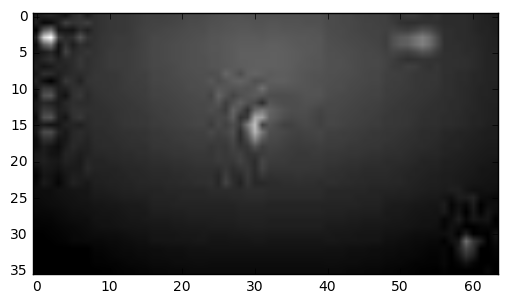

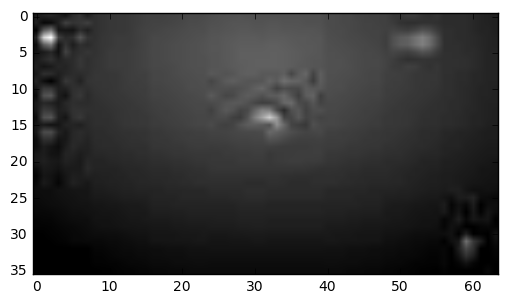

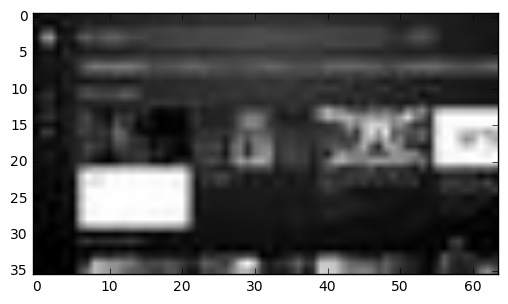

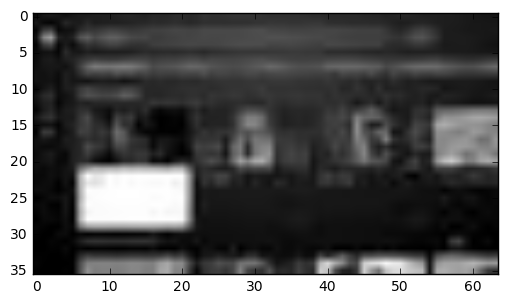

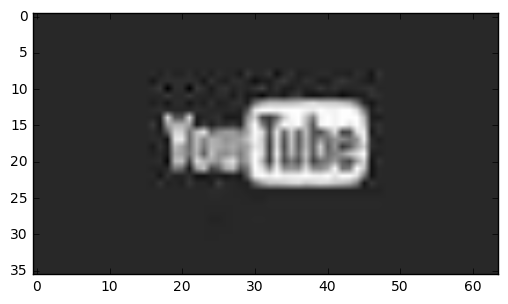

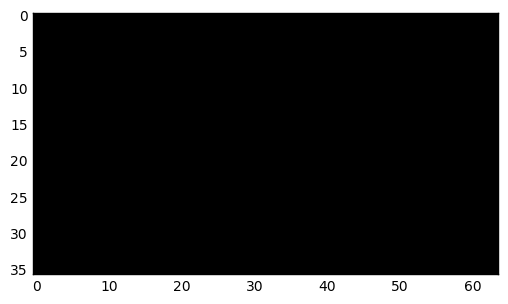

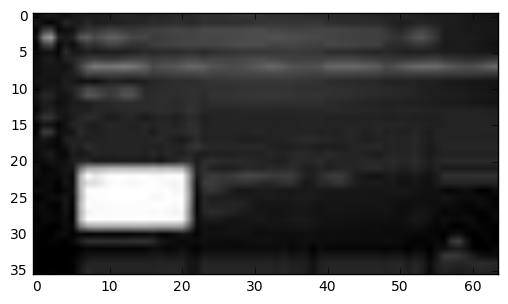

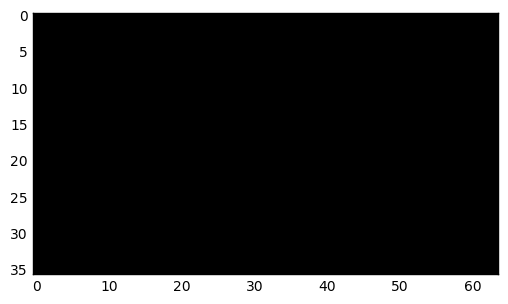

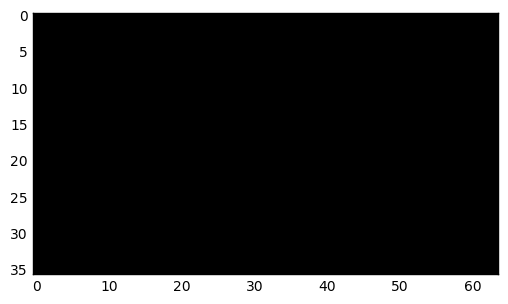

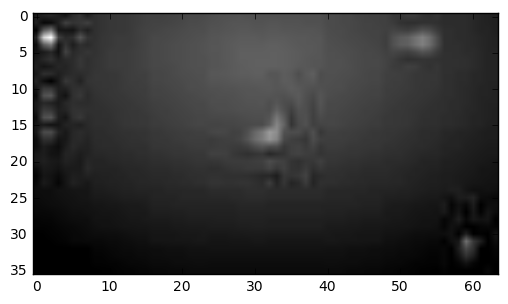

In [4]:
import matplotlib.pyplot as plt
images_np = np.asarray(images_data)
labels_np = np.asarray(labels_data)
test_images_np = np.asarray(test_imgs)
test_labels_np = np.asarray(test_labels)
print(test_images_np.shape)
print(images_np.shape)
def show_image(image):
    plt.imshow(image.reshape(Width, Height), cmap = plt.get_cmap('gray'))
    plt.show()
    
N = len(images_data)
random_image_indices = np.random.randint(0,N,10)

for i in random_image_indices:
    show_image(images_np[i])

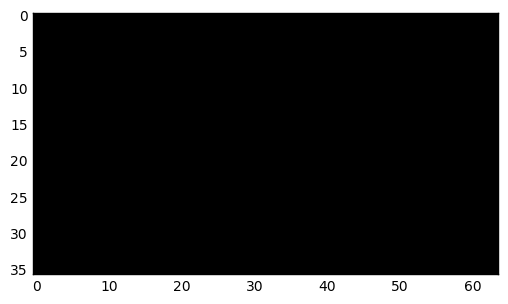

(100, 2304) (100, 5)


In [5]:
def next_batch(num=100):
    indices = np.random.randint(0,N,100)
    return images_np[indices], labels_np[indices]

imgs, lbs = next_batch() 
show_image(imgs[0])
print(imgs.shape, lbs.shape)

In [6]:
print(Width, Height)
logs_path = '/tmp/tensorflow_logs/YouTube'

36 64


In [7]:
import tensorflow as tf
import timeit
model_path = '/tmp/softmax.ckpt'
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, 36*64]) #mnist.train.images[i]
y_ = tf.placeholder(tf.float32, shape=[None, 5])   #mnist.train.labels[i]
W = tf.Variable(tf.zeros([36*64, 5])) # W init, to-do:better with random
b = tf.Variable(tf.zeros([5]))     # b init.   
saver = tf.train.Saver() #'Saver' op to save and restore all the variables

In [8]:
y = tf.matmul(x, W) + b
with tf.name_scope('Loss'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)) # loss function
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

tf.summary.scalar("loss", cross_entropy)
merged_summary_op = tf.summary.merge_all()

In [9]:
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for _ in range(1000):
        batch = next_batch(100) #batch size 100
        train_step.run(feed_dict={x: batch[0], y_: batch[1]})
        #ce_loss, summary = sess.run([cross_entropy, merged_summary_op], feed_dict={x:batch[0], y_:batch[1]})
        #summary_writer.add_summary(summary, i)
        start_time = timeit.default_timer()
    # code you want to evaluate
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    acc = accuracy.eval(feed_dict={x:test_images_np, y_:test_labels_np})
    elapsed = timeit.default_timer() - start_time
    save_path = saver.save(sess, model_path)
print('saved to {}'.format(save_path))
print(acc, elapsed)

saved to /tmp/softmax.ckpt
1.0 0.02349653000055696


In [10]:
print('Restore variables from do validate')
tf.reset_default_graph()
model_path = '/tmp/softmax.ckpt'
x = tf.placeholder(tf.float32, shape=[None, 36*64])
y_ = tf.placeholder(tf.float32, shape=[None, 5])   
W = tf.Variable(tf.zeros([36*64, 5])) # W init
b = tf.Variable(tf.zeros([5]))     # b init.   
y = tf.matmul(x, W) + b
saver = tf.train.Saver() 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, model_path)
    start_time = timeit.default_timer()
    # code you want to evaluate
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    acc = accuracy.eval(feed_dict={x:test_images_np, y_:test_labels_np})
    elapsed = timeit.default_timer() - start_time
print('Accuracy {:.2f}, elapsed time {:.3f}'.format(acc, elapsed))
    

Restore variables from do validate
Accuracy 1.00, elapsed time 0.021


In [37]:
#1-NN
tf.reset_default_graph()
x_train = tf.placeholder(tf.float32, shape=[None, 36*64])
x_test  = tf.placeholder(tf.float32, shape=[36*64])
distance = tf.reduce_sum(tf.abs(tf.add(x_train, tf.negative(x_test))), reduction_indices=1)
predict = tf.arg_min(distance, 0)

accuracy = 0.0
test_counts = len(test_images_np)
indices = np.random.randint(0, len(test_images_np), test_counts)
incorrect = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    correct_count = 0
    start_time = timeit.default_timer()
    for i in range(len(test_images_np)): #indices:#
        nn_index = sess.run(predict, feed_dict={x_train:images_np, x_test:test_images_np[i, :]})
        if np.argmax(labels_np[nn_index]) == np.argmax(test_labels_np[i]):
            correct_count += 1
        else:
            incorrect.append((nn_index, i))
            #print(np.argmax(labels_np[nn_index]), nn_index)
            #show_image(images_np[nn_index])
            #print(np.argmax(test_labels_np[i]))
            #show_image(test_images_np[i])
        #print('Test {} Prediction:{} True Classe:{}', i, np.argmax(labels_np[nn_index]), np.argmax(test_labels_np[i]))
    elapsed = timeit.default_timer() - start_time
print('Accuracy {:.02f} Elapsed {:.02f}'.format(correct_count/test_counts, elapsed))

Accuracy 0.97 Elapsed 36.70


In [38]:
for i,j in incorrect:
    print(i,j)

1534 304
1534 317
1534 319
1540 339
1534 341
1534 344
1540 346
1534 347
1534 350
1534 351
1540 368
1534 370
1543 371
1534 377
1540 385
1534 388
1540 392


[ 0.  0.  1.  0.  0.]


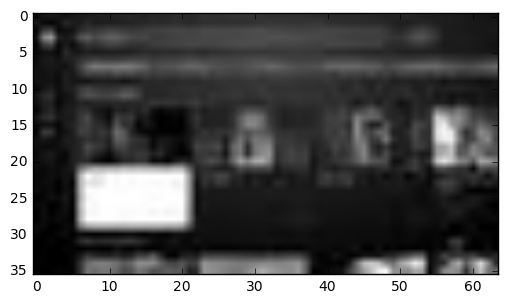

[ 0.  0.  1.  0.  0.]


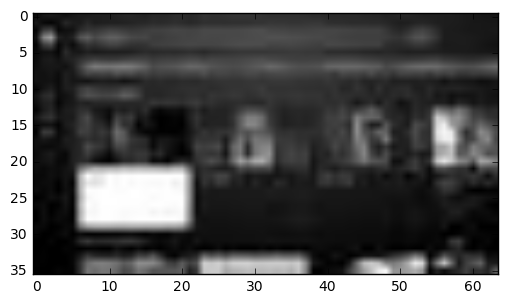

[ 0.  0.  1.  0.  0.]


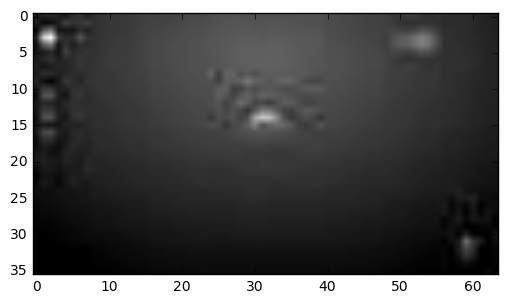

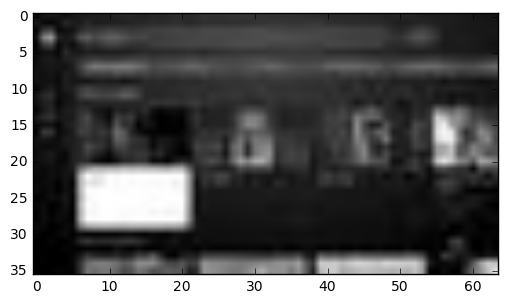

In [35]:
''' Below images are miss labeled!
12_05_2017_12_00_12_0501.thumbnail.jpg
12_05_2017_12_52_39_0501.thumbnail.jpg
12_05_2017_12_54_26_0501.thumbnail.jpg
12_05_2017_12_55_20_0501.thumbnail.jpg
12_05_2017_12_55_38_0501.thumbnail.jpg
'''

print(labels_np[1534])
show_image(images_np[1535])
print(labels_np[1535])
show_image(images_np[1536])
print(labels_np[1536])
show_image(images_np[1540])
show_image(images_np[1541])
